# IA Pau 4 - Surfrider 
## Trash detection and classification - Training pipeline
### By Luca Ordronneau - Moncoutie Johan - Jouanchicot Jordan - Ettarian Julian - Baptiste Urgell

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import pandas as pd
import random
from PIL import Image, ImageDraw, ImageFont, ExifTags
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from matplotlib.pyplot import figure
from shapely.geometry import Polygon
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import cv2
import os
import datetime

## Load Data
### CSV Files from SharePoints (Images/BBOXES)

In [4]:
df_bboxes = pd.read_csv("annotations-surfnet/bounding_boxes_202201241119.csv")
df_images = pd.read_csv("annotations-surfnet/images_for_labelling_202201241120.csv")


In [5]:
df_images.head()

,id,id_creator_fk,createdon,filename,view,image_quality,context,container_url,blob_name
0,774ea7c1-e8ed-4fae-81fd-784c3ce87365,91f946b6-8871-4fbb-8c00-1b6794efb610,2021-05-19 08:56:51,04a90fd6-dbe8-4e35-bc8e-8bdea63bb77d.jpg,NaN,NaN,NaN,https://dataplasticoprod.blob.core.windows.net...,NaN
1,5ec8e4a4-d2e9-4d03-99ed-12e2744ca5ae,954dfaf0-cf84-4e5d-ad9d-0d0d6badb884,2021-05-27 12:15:17,img3316.jpg,side,good,river,NaN,NaN
2,4aa4b452-ce49-4578-a71b-39d99c305e59,954dfaf0-cf84-4e5d-ad9d-0d0d6badb884,2021-05-27 12:15:40,img630.jpg,above,good,river,NaN,NaN
3,ed5d193b-c897-4ebb-9d2d-e1583653923e,954dfaf0-cf84-4e5d-ad9d-0d0d6badb884,2021-05-27 12:14:53,img2387.jpg,side,good,river,NaN,NaN
4,f76656ed-bd4c-4672-b2c0-bc7ddaba2ba3,954dfaf0-cf84-4e5d-ad9d-0d0d6badb884,2021-05-27 12:14:59,img2611.jpg,side,medium,river,NaN,NaN


### Instances Files

In [6]:
coco_train = COCO(annotation_file = 'annotations-surfnet/instances_train.json')
coco_valid = COCO(annotation_file = 'annotations-surfnet/instances_val.json')

coco_images_train = coco_train.dataset['images'][1:]
coco_images_valid = coco_valid.dataset['images'][1:]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [7]:
IMAGES_PATH = "images2label"
images      = os.listdir(IMAGES_PATH)
images_full_path = [os.path.join(IMAGES_PATH, x) for x in os.listdir(IMAGES_PATH)]



## Data Exploration

In [8]:
df_images.head()

,id,id_creator_fk,createdon,filename,view,image_quality,context,container_url,blob_name
0,774ea7c1-e8ed-4fae-81fd-784c3ce87365,91f946b6-8871-4fbb-8c00-1b6794efb610,2021-05-19 08:56:51,04a90fd6-dbe8-4e35-bc8e-8bdea63bb77d.jpg,NaN,NaN,NaN,https://dataplasticoprod.blob.core.windows.net...,NaN
1,5ec8e4a4-d2e9-4d03-99ed-12e2744ca5ae,954dfaf0-cf84-4e5d-ad9d-0d0d6badb884,2021-05-27 12:15:17,img3316.jpg,side,good,river,NaN,NaN
2,4aa4b452-ce49-4578-a71b-39d99c305e59,954dfaf0-cf84-4e5d-ad9d-0d0d6badb884,2021-05-27 12:15:40,img630.jpg,above,good,river,NaN,NaN
3,ed5d193b-c897-4ebb-9d2d-e1583653923e,954dfaf0-cf84-4e5d-ad9d-0d0d6badb884,2021-05-27 12:14:53,img2387.jpg,side,good,river,NaN,NaN
4,f76656ed-bd4c-4672-b2c0-bc7ddaba2ba3,954dfaf0-cf84-4e5d-ad9d-0d0d6badb884,2021-05-27 12:14:59,img2611.jpg,side,medium,river,NaN,NaN


In [9]:
filenames = list(df_images.filename.unique())
len(filenames)

5355

In [10]:
filenames_train = [obj['file_name'] for obj in coco_images_train]
filenames_valid = [obj['file_name'] for obj in coco_images_valid]
print("TRAIN", len(filenames_train), "VALID", len(filenames_valid))
filenames_train_valid = filenames_train + filenames_valid
print("TOTAL", len(filenames_train_valid))

TRAIN 3529 VALID 392
TOTAL 3921


### Files included in CSV and Instances

In [11]:
files_inter = list(set(filenames) & set(filenames_train_valid))
len(files_inter)

3921

### File names of CSVs that are not in Instances

In [12]:
set_difference_f = set(filenames) - set(filenames_train_valid)
list_difference_f = list(set_difference_f)
len(list_difference_f)

1434

### Names of the files of the Instances that are not in CSV

In [14]:
set_difference_i = set(filenames_train_valid) - set(filenames)
list_difference_i = list(set_difference_i)
len(list_difference_i)

0

In [15]:
df_bboxes.head()

,id,id_creator_fk,createdon,id_ref_trash_type_fk,id_ref_images_for_labelling,location_x,location_y,width,height
0,47ff3b15-dc95-4efa-ad3d-b6963db3ef16,954dfaf0-cf84-4e5d-ad9d-0d0d6badb884,2021-06-03 14:10:37,10,744093fe-3112-4577-abf9-6ec24fa1d66e,1934,1284,234,239
1,94164dac-8b99-4fa3-9309-cd6ccbbe855e,954dfaf0-cf84-4e5d-ad9d-0d0d6badb884,2021-06-03 15:35:30,10,9711e35b-67c3-4e76-a5e3-2f7a7204be79,1489,2330,152,162
2,87bcd5d8-c2ac-472e-acd6-8114dcfe5a4a,954dfaf0-cf84-4e5d-ad9d-0d0d6badb884,2021-06-03 15:37:31,1,3bf07139-1e2a-4bba-83ea-86a964e26f05,4033,2026,480,392
3,f52af6e9-15c4-4916-8f4f-3ffda09ada98,954dfaf0-cf84-4e5d-ad9d-0d0d6badb884,2021-06-03 15:41:04,1,b910e724-2a08-4dc7-ab2b-52276b7d9aed,2053,1304,143,167
4,7106288f-7cfd-4f73-9771-6a6b838e5460,954dfaf0-cf84-4e5d-ad9d-0d0d6badb884,2021-06-03 15:43:53,3,36267cf1-891c-4b72-857d-802fa2a3fd04,1603,1431,247,284


### GroupBy ID

<AxesSubplot:title={'center':'Trash Size by ID'}, xlabel='Trash ID', ylabel='Size'>

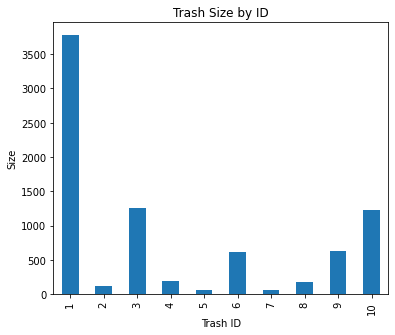

In [16]:
fig, ax = plt.subplots(figsize=(15,7))
dfg = df_bboxes.groupby(['id_ref_trash_type_fk']).size()
dfg.plot(kind='bar', title='Trash Size by ID', ylabel='Size',
         xlabel='Trash ID', figsize=(6, 5))

### GroupBy Context

<AxesSubplot:title={'center':'Context Size by Context'}, xlabel='Context', ylabel='Size'>

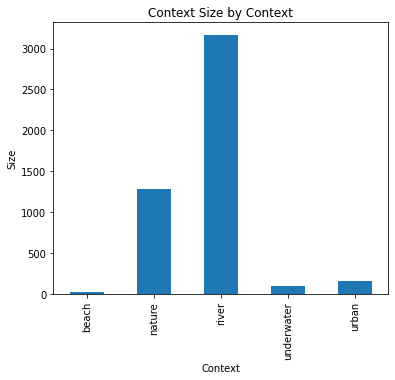

In [17]:
fig, ax = plt.subplots(figsize=(15,7))
dfg = df_images.groupby(['context']).size()
dfg.plot(kind='bar', title='Context Size by Context', ylabel='Size',
         xlabel='Context', figsize=(6, 5))

### GroupBy View

<AxesSubplot:title={'center':'View Size by View'}, xlabel='View', ylabel='Size'>

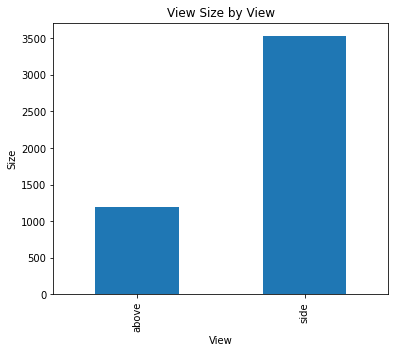

In [18]:
fig, ax = plt.subplots(figsize=(15,7))
dfg = df_images.groupby(['view']).size()
dfg.plot(kind='bar', title='View Size by View', ylabel='Size',
         xlabel='View', figsize=(6, 5))

### GroupBy Image quality

<AxesSubplot:title={'center':'Image Quality Size by Image Quality'}, xlabel='Image Quality', ylabel='Size'>

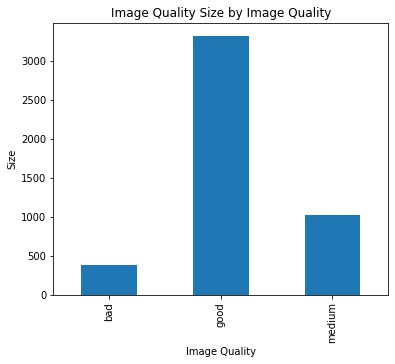

In [19]:
fig, ax = plt.subplots(figsize=(15,7))
dfg = df_images.groupby(['image_quality']).size()
dfg.plot(kind='bar', title='Image Quality Size by Image Quality', ylabel='Size',
         xlabel='Image Quality', figsize=(6, 5))

## Data Processing

In [21]:
def coco2yolo(bbox, image_height=1080, image_width=1080):
    """
    coco  => [x1, y1, w, h]
    yolo  => [xmid, ymid, w, h] (normalized)
    """
    
    bbox = bbox.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int

    bbox[[0, 2]] = bbox[[0, 2]]/ image_width
    bbox[[1, 3]] = bbox[[1, 3]]/ image_height
    
    bbox[[0, 1]] = bbox[[0, 1]] + bbox[[2, 3]]/2
    
    return bbox

In [22]:
def plot_image_and_bboxes(img, anns, ratio):
    fig, ax = plt.subplots(1, figsize=(12, 10))
    ax.imshow(img)
    
    for ann in anns:
        [bbox_x, bbox_y, bbox_w, bbox_h] = (ratio*np.array(ann['bbox'])).astype(int)
        rect = patches.Rectangle((bbox_x, bbox_y), bbox_w, bbox_h, linewidth=2, edgecolor='r', facecolor="none")
        ax.add_patch(rect)
    
    plt.show()

In [23]:
!mkdir ./images
!mkdir ./labels

La syntaxe de la commande n'est pas correcte.
La syntaxe de la commande n'est pas correcte.


### Get categories

In [24]:
annotation_file = "annotations-surfnet/instances_train.json"
coco = COCO(annotation_file)

coco_categories = coco.dataset['categories'][1:]
class_id_to_name_mapping = {}
for c in coco_categories:
    class_id_to_name_mapping[c['id']-1] = c['name']

class_id_to_name_mapping

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


{1: 'Insulating material',
 4: 'Drum',
 2: 'Bottle-shaped',
 3: 'Can-shaped',
 5: 'Other packaging',
 6: 'Tire',
 7: 'Fishing net / cord',
 8: 'Easily namable',
 9: 'Unclear',
 0: 'Sheet / tarp / plastic bag / fragment'}

### Creation of 2 DataFrames for futur manipulation (GroupKFold, KFold, Split...)

In [25]:
data_dir = "images2label"

def get_df_train_val(annotation_file):
    
    coco = COCO(annotation_file)

    old_filenames  = []
    dates          = []
    views          = []
    images_quality = []
    contexts       = []
    all_bboxes     = []
    all_images     = []
    new_filenames  = []
    new_labelnames = []

    img_ids = np.array(coco.getImgIds())
    
    for img_id in img_ids:
        image_infos = coco.loadImgs(ids=[img_id])[0]

        if os.path.exists(os.path.join(data_dir, image_infos['file_name'])):

            date_creation  = df_images.loc[df_images["filename"] == image_infos["file_name"]]["createdon"].values[0]
            view           = df_images.loc[df_images["filename"] == image_infos["file_name"]]["view"].values[0]
            image_quality  = df_images.loc[df_images["filename"] == image_infos["file_name"]]["image_quality"].values[0]
            context        = df_images.loc[df_images["filename"] == image_infos["file_name"]]["context"].values[0]

            date_time_obj = datetime.datetime.strptime(date_creation, '%Y-%m-%d %H:%M:%S')

            old_filenames.append(image_infos["file_name"])
            dates.append(date_time_obj)
            views.append(view)
            images_quality.append(image_quality)
            contexts.append(context)

            image = Image.open(os.path.join(data_dir,image_infos['file_name']))
            try:
                for orientation in ExifTags.TAGS.keys():
                    if ExifTags.TAGS[orientation]=='Orientation':
                        break
                exif = image._getexif()
                if exif is not None:
                    if exif[orientation] == 3:
                        image=image.rotate(180, expand=True)
                    elif exif[orientation] == 6:
                        image=image.rotate(270, expand=True)
                    elif exif[orientation] == 8:
                        image=image.rotate(90, expand=True)

            except (AttributeError, KeyError, IndexError):
                # cases: image don't have getexif
                pass

            image    = np.array(image) #cv2.cvtColor(np.array(image.convert('RGB')),  cv2.COLOR_RGB2BGR)
            ann_ids  = coco.getAnnIds(imgIds=[img_id])
            anns     = coco.loadAnns(ids=ann_ids)
            h, w     = image.shape[:-1]
            target_h = 1080
            ratio    = target_h/h
            target_w = int(ratio*w) 
            image    = cv2.resize(image,(target_w,target_h))
            h, w     = image.shape[:-1]
            yolo_annot = []
            for ann in anns:
                cat = ann['category_id'] - 1
                [bbox_x, bbox_y, bbox_w, bbox_h] = (ratio*np.array(ann['bbox'])).astype(int)
                bbox = np.array([bbox_x, bbox_y, bbox_w, bbox_h])
                yolo_bbox = coco2yolo(bbox, target_h, target_w)
                yolo_str  = str(cat) + " " + " ".join(yolo_bbox.astype(str))
                yolo_annot.append(yolo_str)
            
            basename  = os.path.splitext(image_infos['file_name'])[0]
            file_name = str(image_infos['id']) + "-" + basename

            img_file_name   = os.path.join("./images", file_name) + ".jpg"
            label_file_name = os.path.join("./labels", file_name) + ".txt"
            
            # Save Label
            with open(label_file_name, 'w') as f:
                f.write('\n'.join(yolo_annot))

            img_to_save = Image.fromarray(image)
            # Save image
            img_to_save.save(img_file_name)

            all_bboxes.append(yolo_annot)
            new_filenames.append(img_file_name)
            new_labelnames.append(label_file_name)
            all_images.append(img_to_save)
            
    my_list = list(zip(old_filenames, dates, views, images_quality, contexts, new_filenames, new_labelnames, all_images, all_bboxes))
    my_df   = pd.DataFrame(my_list, columns=['old_path', 'date', 'view', 'quality','context', 'img_name', 'label_name', 'img', 'bboxes'])
    
    return my_df

df_train = get_df_train_val("annotations-surfnet/instances_train.json")
df_valid = get_df_train_val("annotations-surfnet/instances_val.json")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [26]:
df_train.head()

,old_path,date,view,quality,context,img_name,label_name,img,bboxes
0,img1813.jpg,2021-05-27 12:14:39,side,good,river,./images\6-img1813.jpg,./labels\6-img1813.txt,<PIL.Image.Image image mode=RGB size=810x1080 ...,[2 0.4858024691358025 0.4546296296296296 0.087...
1,img1282.jpg,2021-05-27 12:14:25,side,good,river,./images\15-img1282.jpg,./labels\15-img1282.txt,<PIL.Image.Image image mode=RGB size=810x1080 ...,[0 0.44012345679012344 0.43194444444444446 0.1...
2,img441.jpg,2021-05-27 12:15:35,side,good,river,./images\18-img441.jpg,./labels\18-img441.txt,<PIL.Image.Image image mode=RGB size=810x1080 ...,[0 0.7376543209876543 0.4847222222222222 0.028...
3,img2210.JPG,2021-05-27 12:14:49,side,good,nature,./images\25-img2210.jpg,./labels\25-img2210.txt,<PIL.Image.Image image mode=RGB size=1620x1080...,[2 0.4679012345679012 0.46064814814814814 0.04...
4,img1325.jpg,2021-05-27 12:14:26,side,good,river,./images\30-img1325.jpg,./labels\30-img1325.txt,<PIL.Image.Image image mode=RGB size=810x1080 ...,[0 0.5629629629629629 0.47824074074074074 0.02...


In [27]:
df_valid.head()

,old_path,date,view,quality,context,img_name,label_name,img,bboxes
0,img51.jpg,2021-05-27 12:15:37,above,good,urban,./images\7-img51.jpg,./labels\7-img51.txt,<PIL.Image.Image image mode=RGB size=631x1080 ...,[3 0.4508716323296355 0.6148148148148148 0.226...
1,c25affab-a2e3-4156-973b-436aab8a12e3(7).jpg,2021-08-21 11:48:20,above,good,urban,./images\31-c25affab-a2e3-4156-973b-436aab8a12...,./labels\31-c25affab-a2e3-4156-973b-436aab8a12...,<PIL.Image.Image image mode=RGB size=810x1080 ...,[0 0.45 0.4375 0.8827160493827161 0.8416666666...
2,img2169.JPG,2021-05-27 12:14:48,side,bad,nature,./images\54-img2169.jpg,./labels\54-img2169.txt,<PIL.Image.Image image mode=RGB size=1923x1080...,[0 0.6734269370774831 0.5087962962962963 0.038...
3,img3001.JPG,2021-05-27 12:15:09,side,medium,river,./images\69-img3001.jpg,./labels\69-img3001.txt,<PIL.Image.Image image mode=RGB size=1620x1080...,[2 0.6172839506172839 0.6069444444444444 0.092...
4,img1439.jpg,2021-05-27 12:14:29,side,good,river,./images\75-img1439.jpg,./labels\75-img1439.txt,<PIL.Image.Image image mode=RGB size=1440x1080...,[0 0.4944444444444444 0.514351851851852 0.0069...


In [28]:
print(len(df_train),len(df_valid))

260 23


### Group DataFrames for futur manipulation

In [29]:
frames = [df_train, df_valid]
df_train_valid = pd.concat(frames)

df_train_valid.head()

,old_path,date,view,quality,context,img_name,label_name,img,bboxes
0,img1813.jpg,2021-05-27 12:14:39,side,good,river,./images\6-img1813.jpg,./labels\6-img1813.txt,<PIL.Image.Image image mode=RGB size=810x1080 ...,[2 0.4858024691358025 0.4546296296296296 0.087...
1,img1282.jpg,2021-05-27 12:14:25,side,good,river,./images\15-img1282.jpg,./labels\15-img1282.txt,<PIL.Image.Image image mode=RGB size=810x1080 ...,[0 0.44012345679012344 0.43194444444444446 0.1...
2,img441.jpg,2021-05-27 12:15:35,side,good,river,./images\18-img441.jpg,./labels\18-img441.txt,<PIL.Image.Image image mode=RGB size=810x1080 ...,[0 0.7376543209876543 0.4847222222222222 0.028...
3,img2210.JPG,2021-05-27 12:14:49,side,good,nature,./images\25-img2210.jpg,./labels\25-img2210.txt,<PIL.Image.Image image mode=RGB size=1620x1080...,[2 0.4679012345679012 0.46064814814814814 0.04...
4,img1325.jpg,2021-05-27 12:14:26,side,good,river,./images\30-img1325.jpg,./labels\30-img1325.txt,<PIL.Image.Image image mode=RGB size=810x1080 ...,[0 0.5629629629629629 0.47824074074074074 0.02...


In [30]:
d = df_train_valid.iloc[0]["date"]
def get_day(d):
    d = d.date()
    return int("".join(str(d).split("-")))

df_train_valid["day"] = df_train_valid["date"].apply(lambda x: get_day(x))
df_train_valid.head()

,old_path,date,view,quality,context,img_name,label_name,img,bboxes,day
0,img1813.jpg,2021-05-27 12:14:39,side,good,river,./images\6-img1813.jpg,./labels\6-img1813.txt,<PIL.Image.Image image mode=RGB size=810x1080 ...,[2 0.4858024691358025 0.4546296296296296 0.087...,20210527
1,img1282.jpg,2021-05-27 12:14:25,side,good,river,./images\15-img1282.jpg,./labels\15-img1282.txt,<PIL.Image.Image image mode=RGB size=810x1080 ...,[0 0.44012345679012344 0.43194444444444446 0.1...,20210527
2,img441.jpg,2021-05-27 12:15:35,side,good,river,./images\18-img441.jpg,./labels\18-img441.txt,<PIL.Image.Image image mode=RGB size=810x1080 ...,[0 0.7376543209876543 0.4847222222222222 0.028...,20210527
3,img2210.JPG,2021-05-27 12:14:49,side,good,nature,./images\25-img2210.jpg,./labels\25-img2210.txt,<PIL.Image.Image image mode=RGB size=1620x1080...,[2 0.4679012345679012 0.46064814814814814 0.04...,20210527
4,img1325.jpg,2021-05-27 12:14:26,side,good,river,./images\30-img1325.jpg,./labels\30-img1325.txt,<PIL.Image.Image image mode=RGB size=810x1080 ...,[0 0.5629629629629629 0.47824074074074074 0.02...,20210527


### GroupKFold by Day (**With the big dataset**)

In [31]:
# from sklearn.model_selection import GroupKFold

# kf = GroupKFold(n_splits = 5) 
# df_train_valid = df_train_valid.reset_index(drop=True)
# df_train_valid['fold'] = -1

# for fold, (train_idx, val_idx) in enumerate(kf.split(df_train_valid, y = df_train_valid.context.tolist(), groups=df_train_valid.day)):
#     df_train_valid.loc[val_idx, 'fold'] = fold

# display(df_train_valid.fold.value_counts())

### Simple KFold

In [32]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=7)
df_train_valid = df_train_valid.reset_index(drop=True)
df_train_valid['fold'] = -1

for fold, (train_idx, val_idx) in enumerate(kf.split(df_train_valid)):
    df_train_valid.loc[val_idx, 'fold'] = fold

display(df_train_valid.fold.value_counts())

2    41
1    41
0    41
6    40
5    40
4    40
3    40
Name: fold, dtype: int64

In [33]:
FOLD = 1

train_files = []
val_files   = []
train_df = df_train_valid.query("fold!=@FOLD")
valid_df = df_train_valid.query("fold==@FOLD")

train_files = list(train_df["img_name"].unique())
val_files   = list(valid_df["img_name"].unique())
len(train_files), len(val_files)

(242, 41)

In [34]:
print("Train", 100 * len(train_files)/(len(train_files)+len(val_files)))
print("Valid", 100 * len(val_files)/(len(train_files)+len(val_files)))

Train 85.51236749116607
Valid 14.487632508833922


In [35]:
def plot_image_an_bboxes_yolo(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline="#ff8300", width=5)
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.figure(figsize = (12,10))
    plt.imshow(np.array(image))
    plt.show()

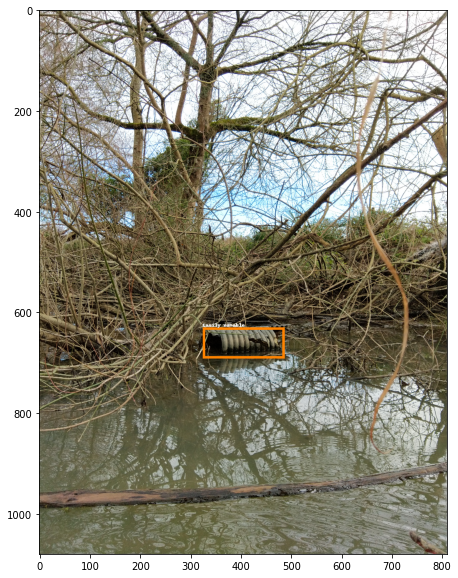

In [36]:
row        = df_train_valid.iloc[282]
img_name   = os.path.join("images-surfnet/images2label", row["old_path"])
img        = row["img"]
label_list = row["bboxes"]
label_list = [x.split(" ") for x in label_list]
label_list = [[float(y) for y in x ] for x in label_list]

plot_image_an_bboxes_yolo(img, label_list)

## Training

In [37]:
# import wandb
# !wandb login <API_KEY>

### To improve, try choose best model with F1 score (Futur work)

In [38]:
!git clone https://github.com/ultralytics/yolov5.git

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [39]:
import yaml

cwd = './'

with open(os.path.join( cwd , 'train.txt'), 'w') as f:
    for path in train_files:
        f.write(path+'\n')
            
with open(os.path.join(cwd , 'val.txt'), 'w') as f:
    for path in val_files:
        f.write(path+'\n')

data = dict(
    path  = './../',
    train =  os.path.join( cwd , 'train.txt') ,
    val   =  os.path.join( cwd , 'val.txt' ),
    nc    = 10,
    names = ['Sheet / tarp / plastic bag / fragment', 'Insulating material', 'Bottle-shaped', 'Can-shaped', 'Drum', 'Other packaging', 'Tire', 'Fishing net / cord', 'Easily namable', 'Unclear'],
    )

with open(os.path.join( cwd , 'data.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(os.path.join( cwd , 'data.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Sheet / tarp / plastic bag / fragment
- Insulating material
- Bottle-shaped
- Can-shaped
- Drum
- Other packaging
- Tire
- Fishing net / cord
- Easily namable
- Unclear
nc: 10
path: ./../
train: ./train.txt
val: ./val.txt



### Change % of some augmentations

In [41]:
%%writefile yolov5/data/hyps/hyp.scratch.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# Hyperparameters for COCO training from scratch
# python train.py --batch 40 --cfg yolov5m.yaml --weights '' --data coco.yaml --img 640 --epochs 300
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.012  # image HSV-Hue augmentation (fraction)
hsv_s: 0.6  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.3  # image HSV-Value augmentation (fraction)
degrees: 2.0  # image rotation (+/- deg)
translate: 0.3  # image translation (+/- fraction)
scale: 0.25  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.1  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 0.7  # image mosaic (probability)
mixup: 0.0  # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)

Overwriting yolov5/data/hyps/hyp.scratch.yaml


### A model trained with higher resolution images can have better results for detecting small objects

In [1]:
 !python "yolov5/train.py" --img 640 --hyp "yolov5/data/hyps/hyp.scratch.yaml" --batch 20 --epochs 30 --data "data.yaml" --weights "yolov5s.pt" --workers 23 --project "IAPAU4" --name "yolo_ia_pau_4" --exist-ok 

train: weights=yolov5s.pt, cfg=, data=data.yaml, hyp=yolov5/data/hyps/hyp.scratch.yaml, epochs=30, batch_size=20, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=23, project=IAPAU4, name=yolo_ia_pau_4, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
From https://github.com/ultralytics/yolov5
   bc3ed95..a0a4adf  master              -> origin/master
   6db0481..fc34bb2  test/conv_reduction -> origin/test/conv_reduction
github:  YOLOv5 is out of date by 2 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5  v6.1-60-gc3ae4e4 torch 1.11.0+cpu CPU

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs

### To create separate class trainings, the classes must be normalized
The separation of the classes was done with scripts, and linux commands.
The main idea: Go through all YOLO txt files and remove useless classes

In [ ]:
# 'Sheet / tarp / plastic bag / fragment'} 0
# 'Insulating material' 1 'Can-shaped' : 3 'Easily namable' 8 'Fishing net / cord' 7 Tire' 6 'Other packaging' 5 
# 'Bottle-shaped' 2 'Unclear' 9

t_0 = {0:0}
t_1 = {1:0, 3:1, 4:2, 5:3, 6:4, 7:5, 8:6}          
t_2 = {2:0, 9:1}

### Code for ensemble

In [ ]:
import torch
import numpy as np
from PIL import Image
from ensemble_boxes import *

IMG_SIZE = 960 

id_categories = {1: 'Insulating material',
 4: 'Drum',
 2: 'Bottle-shaped',
 3: 'Can-shaped',
 5: 'Other packaging',
 6: 'Tire',
 7: 'Fishing net / cord',
 8: 'Easily namable',
 9: 'Unclear',
 0: 'Sheet / tarp / plastic bag / fragment'}

categories_id = {v: k for k, v in id_categories.items()}

def get_id(cat):
    return categories_id[cat]

def load_model(model_path, conf=0.35, iou=0.50):
    model = torch.hub.load('yolov5','custom', path=model_path, source='local', force_reload=True)
    model.conf = conf
    model.iou  = iou
    model.classes = None
    model.multi_label = False
    model.max_det = 1000
    return model

def voc2coco(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y2]
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes[..., 2:4] -= bboxes[..., 0:2]
    return bboxes

def predict(model, img, size=768, augment=False):
    results = model(img, size=size, augment=augment)
    preds   = results.pandas().xyxy[0]
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values # voc format
    if len(bboxes):
        bboxes  = bboxes.astype(int)
        confs   = preds.confidence.values
        labels  = np.array(list(map(get_id, preds.name.values)))
        return bboxes, confs, labels
    else:
        return np.array([]), np.array([]), np.array([])


def get_image(img_name):
    return np.array(Image.open(img_name))


def run_wbf(bboxes, confs, classs, image_size, iou_thr=0.5, skip_box_thr=0.0001, weights=None):
    boxes  =  [bbox/(image_size-1) for bbox in bboxes]
    scores = [conf for conf in confs]  
    labels = [np.ones(conf.shape[0]) for conf in classs]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [ ]:
l1 = load_model("weights/best-l1.pt", conf=0.3, iou=0.50)
l2 = load_model("weights/best-l2.pt", conf=0.1, iou=0.50)
l3 = load_model("weights/best-l3.pt", conf=0.15, iou=0.50)

img_name = "inf_images_ia_pau_4/img(146).jpeg"

img = get_image(img_name)
height, width = img.shape[:2]       

bboxes_1, confs_1, labels_1 = predict(l1, img, IMG_SIZE, True)
bboxes_2, confs_2, labels_2 = predict(l2, img, IMG_SIZE, True)
bboxes_3, confs_3, labels_3 = predict(l3, img, IMG_SIZE, True)

bboxes_list = [bboxes_1,bboxes_2,bboxes_3]
confs_list  = [confs_1,confs_2,confs_3]
labels_list = [labels_1,labels_2,labels_3]

bboxes, confs, labels  = run_wbf(bboxes_list, confs_list, labels_list, max(height, width))

bboxes = voc2coco(bboxes, height, width)

In [ ]:
def plot_image_and_bboxes(img, bboxes):
    fig, ax = plt.subplots(1, figsize=(12, 10))
    ax.imshow(img)
    
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor="none")
        ax.add_patch(rect)
    
    plt.show()

plot_image_and_bboxes(img, bboxes) 